In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import pandas as pd
import numpy as np
import pickle
import sys

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, recall_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback

In [4]:
df_train = pd.read_csv(project.get_file('features_train.csv'),index_col=0)

<h1 style="font-size:10 em">Model Training</h1>

For validation purposes, we do a standard train-test split on the overall training set df_train and check a few different models.  We look at a simple logistic regression, a simple decision tree, and a gradient-boosted decision tree.

In addition, in partial fulfillment of the IBM Advanced Data Science Capstone Project requirements, we train a simple feed-forward neural network with one hidden layer and a handful of nodes.

We evaluate on several metrics: (1) area under the ROC curve; (2) average precision; (3) recall using an optimized decision threshold; and (4) precision using an optimized decision threshold.  (The thresholds are chosen so as to maximize the harmonic mean of precision and recall.)

Since we are conducting a "needle-in-a-haystack" search for recipes with the potential to cross the popularity threshold, we prioritize average precision as our key metric.  Our goal is to provide Food.com proprietors with a reasonable (not too large) list of recipes which are good candidates for promotional marketing.  Recall is a bit less important for our purposes, as is False Positive Rate (embedded in ROC AUC score).

In the end we can see that the simplest model, logistic regression, performs best.  So we export the model (along with its threshold) to be evaluated later on the test set.  (The fact that more complicated models do not outperform simple ones here is, I hope, a testament to good feature selection!)

In [22]:
X_train,X_test,y_train,y_test = train_test_split(df_train.drop(columns='target'),df_train['target'], random_state=0)

In [23]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [24]:
LR_clfr = LogisticRegression().fit(X_train_scaled,y_train)

DT_clfr = DecisionTreeClassifier().fit(X_train_scaled,y_train)

GBT_clfr = GradientBoostingClassifier().fit(X_train_scaled,y_train)

In [9]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr = LossHistory()

In [10]:
#sgd = optimizers.sgd(lr=0.01, clipnorm=1.)

NN_clfr = Sequential()
NN_clfr.add(Dense(8,input_shape=(13, ), activation='relu'))
#model.add(Dense(10, activation='relu'))
NN_clfr.add(Dense(1, activation='sigmoid'))
NN_clfr.compile(loss='binary_crossentropy', optimizer='adam')

NN_clfr.fit(X_train_scaled, y_train, epochs=5, batch_size=256, validation_data=(X_test,y_test), verbose=2, shuffle=True,callbacks=[lr])

Train on 171155 samples, validate on 57052 samples
Epoch 1/5
0.6984244, 0.6892073, 0.68673056, 0.68328476, 0.68680066, 0.67599714, 0.6774574, 0.6711834, 0.6709288, 0.6720253, 0.6715049, 0.66453594, 0.6600824, 0.65180486, 0.6546676, 0.65806544, 0.6484052, 0.6452203, 0.6424887, 0.6400323, 0.6403408, 0.63910395, 0.63469446, 0.63665116, 0.62616014, 0.62236744, 0.6226785, 0.61990404, 0.6148926, 0.61916333, 0.61788183, 0.60479087, 0.6040702, 0.59985197, 0.60252714, 0.59555817, 0.595239, 0.5889324, 0.5931046, 0.58177114, 0.57448775, 0.5778978, 0.5762903, 0.5711317, 0.58034813, 0.5791433, 0.56917816, 0.5611317, 0.5632001, 0.5514878, 0.55341244, 0.5439133, 0.5447943, 0.5353954, 0.54632723, 0.5332133, 0.5385398, 0.52928126, 0.5367284, 0.5183681, 0.5241692, 0.51859915, 0.51189685, 0.50171804, 0.50849575, 0.4997021, 0.5027139, 0.49732363, 0.49222898, 0.49124265, 0.48058325, 0.48081738, 0.473974, 0.47064784, 0.47112334, 0.46360636, 0.45539615, 0.45618582, 0.45463368, 0.45277092, 0.44984433, 0.43850

In [25]:
LR_predictions = LR_clfr.predict_proba(X_test_scaled)[:,1]

DT_predictions = DT_clfr.predict_proba(X_test_scaled)[:,1]

GBT_predictions = GBT_clfr.predict_proba(X_test_scaled)[:,1]

In [26]:
prec, rec, thresholds = precision_recall_curve(y_test,LR_predictions)
LR_thresh = thresholds[np.argmax(np.sqrt(prec * rec))]

prec, rec, thresholds = precision_recall_curve(y_test,DT_predictions)
DT_thresh = thresholds[np.argmax(np.sqrt(prec * rec))]

prec, rec, thresholds = precision_recall_curve(y_test,GBT_predictions)
GBT_thresh = thresholds[np.argmax(np.sqrt(prec * rec))]

print('Logistic Regression:')
print(roc_auc_score(y_test,LR_predictions), average_precision_score(y_test,LR_predictions), 
      recall_score(y_test,(LR_predictions >= LR_thresh)), precision_score(y_test,(LR_predictions >= LR_thresh)))
print('Decision Tree:')
print(roc_auc_score(y_test,DT_predictions), average_precision_score(y_test,DT_predictions), 
      recall_score(y_test,(DT_predictions >= DT_thresh)), precision_score(y_test,(DT_predictions >= DT_thresh)))
print('Gradient-Boosted Decision Trees:')
print(roc_auc_score(y_test,GBT_predictions), average_precision_score(y_test,GBT_predictions), 
      recall_score(y_test,(GBT_predictions >= GBT_thresh)), precision_score(y_test,(GBT_predictions >= GBT_thresh)))

Logistic Regression:
0.999711718450214 0.3585948107817436 0.8888888888888888 0.27586206896551724
Decision Tree:
0.6665439522231766 0.058928696627637944 0.3333333333333333 0.17647058823529413
Gradient-Boosted Decision Trees:
0.9995373860265258 0.1682738788001946 0.7777777777777778 0.18421052631578946


In [15]:
NN_predictions = 1 - NN_clfr.predict(X_test_scaled)

In [16]:
prec, rec, thresholds = precision_recall_curve(y_test,NN_predictions)
NN_thresh = thresholds[np.argmax(np.sqrt(prec * rec))]

print('Neural Network:')
print(roc_auc_score(y_test,NN_predictions), average_precision_score(y_test,NN_predictions), 
      recall_score(y_test,(NN_predictions >= NN_thresh)), precision_score(y_test,(NN_predictions >= NN_thresh)))

Neural Network:
0.6163761450913249 0.00021288360921912976 1.0 0.00025076623014767347


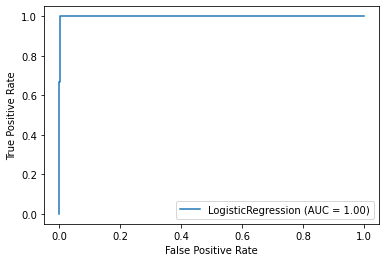

In [90]:
plot_roc_curve(LR_clfr,X_test_scaled,y_test)

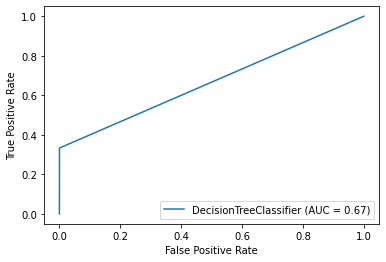

In [91]:
plot_roc_curve(DT_clfr,X_test_scaled,y_test)

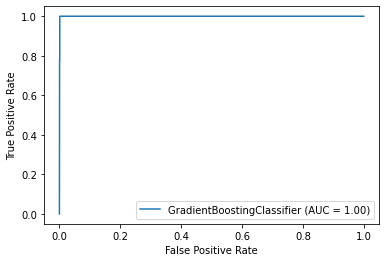

In [92]:
plot_roc_curve(GBT_clfr,X_test_scaled,y_test)

In [17]:
scaler = MinMaxScaler().fit(df_train.drop(columns='target'))

df_train_scaled = scaler.transform(df_train.drop(columns='target'))

LR_clfr = LogisticRegression().fit(df_train_scaled,df_train['target'])

In [18]:
project.save_data('scaler_and_LR_clfr_and_thresh.pkl', pickle.dumps((scaler, LR_clfr, LR_thresh)), set_project_asset=True, overwrite=True)

{'file_name': 'scaler_and_LR_clfr_and_thresh.pkl',
 'message': 'File saved to project storage.',
 'bucket_name': 'foodcomrecipepopularitypredictor-donotdelete-pr-wiqbzxzcs7ksbf',
 'asset_id': 'fd5fe11e-f962-4203-98db-b6877bad7987'}

<h1>Appendix 1: Comparison of Model Without Network Analysis Features<h1>

In [12]:
df_train_partial_1 = pd.read_csv(project.get_file('features_train_partial.csv'),index_col=0) # Load dataset without network features (Innovation Jaccard and Average Innovation Jaccard)
df_train_partial_1.fillna(0,inplace=True)

df_train_partial_1

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF
recipe_id,,,,,,,,,,,,
38,0,4,5624,0.000711,1.190284e-01,4.250000,1485,13,4,170.9,28.360140,0.008057
39,0,1,5604,0.000178,1.485670e-02,3.000000,265,17,26,1110.7,33.459893,0.044122
40,0,9,5597,0.001608,5.000000e-01,4.333333,35,8,6,311.1,15.944444,0.034354
41,0,2,5599,0.000357,4.268798e-03,4.500000,1460,18,15,536.1,31.488889,0.036272
43,0,1,5612,0.000178,3.387240e-08,1.000000,140,35,15,437.9,28.777387,0.073402
...,...,...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,0.000000,1.303901e-08,0.000000,35,10,6,206.6,31.076623,0.106498
520248,0,1,3,0.333333,1.055873e-01,5.000000,15,9,7,473.7,30.761905,0.019886
520250,0,1,3,0.333333,3.360625e-06,5.000000,30,11,12,251.5,31.080946,0.046461


In [19]:
X_train_partial_1,X_test_partial_1,y_train_partial_1,y_test_partial_1 = train_test_split(df_train_partial_1.drop(columns='target'),df_train_partial_1['target'], random_state=0)

scaler = MinMaxScaler().fit(X_train_partial_1)

X_train_partial_1_scaled = scaler.transform(X_train_partial_1)

X_test_partial_1_scaled = scaler.transform(X_test_partial_1)

LR_clfr_partial_1 = LogisticRegression().fit(X_train_partial_1_scaled,y_train_partial_1)

LR_partial_1_predictions = LR_clfr_partial_1.predict_proba(X_test_partial_1_scaled)[:,1]

prec, rec, thresholds = precision_recall_curve(y_test_partial_1,LR_partial_1_predictions)
LR_partial_1_thresh = thresholds[np.argmax(np.sqrt(prec * rec))]

print('Logistic Regression:')
print(roc_auc_score(y_test_partial_1,LR_partial_1_predictions), average_precision_score(y_test_partial_1,LR_partial_1_predictions), 
      recall_score(y_test_partial_1,(LR_partial_1_predictions >= LR_partial_1_thresh)), precision_score(y_test_partial_1,(LR_partial_1_predictions >= LR_partial_1_thresh)))

Logistic Regression:
0.9996941878154297 0.3447152733891085 0.8888888888888888 0.25806451612903225


In [29]:
print('Gain in ROC AUC with network analysis features:')
print(str(roc_auc_score(y_test,LR_predictions) - roc_auc_score(y_test_partial_1,LR_partial_1_predictions)))
print('Gain in average precision with network analysis features:')
print(str(average_precision_score(y_test,LR_predictions) - average_precision_score(y_test_partial_1,LR_partial_1_predictions)))
print('Gain in recall with network analysis features:')
print(str(recall_score(y_test,(LR_predictions >= LR_thresh)) - recall_score(y_test_partial_1,(LR_partial_1_predictions >= LR_partial_1_thresh))))
print('Gain in precision with network analysis features:')
print(str(precision_score(y_test,(LR_predictions >= LR_thresh)) - precision_score(y_test_partial_1,(LR_partial_1_predictions >= LR_partial_1_thresh))))

Gain in ROC AUC with network analysis features:
1.753063478426853e-05
Gain in average precision with network analysis features:
0.013879537392635088
Gain in recall with network analysis features:
0.0
Gain in precision with network analysis features:
0.017797552836484987


<h1>Appendix 2: Comparison of Model Without RUS-Boosted Probability Feature<h1>

In [30]:
df_train_partial_2 = df_train_partial_1.drop(columns='RUSNB_proba_pred')

df_train_partial_2

,target,total_ratings_curr,age_in_days,rating_pace,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF
recipe_id,,,,,,,,,,,
38,0,4,5624,0.000711,4.250000,1485,13,4,170.9,28.360140,0.008057
39,0,1,5604,0.000178,3.000000,265,17,26,1110.7,33.459893,0.044122
40,0,9,5597,0.001608,4.333333,35,8,6,311.1,15.944444,0.034354
41,0,2,5599,0.000357,4.500000,1460,18,15,536.1,31.488889,0.036272
43,0,1,5612,0.000178,1.000000,140,35,15,437.9,28.777387,0.073402
...,...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,0.000000,0.000000,35,10,6,206.6,31.076623,0.106498
520248,0,1,3,0.333333,5.000000,15,9,7,473.7,30.761905,0.019886
520250,0,1,3,0.333333,5.000000,30,11,12,251.5,31.080946,0.046461


In [32]:
X_train_partial_2,X_test_partial_2,y_train_partial_2,y_test_partial_2 = train_test_split(df_train_partial_2.drop(columns='target'),df_train_partial_2['target'], random_state=0)

scaler = MinMaxScaler().fit(X_train_partial_2)

X_train_partial_2_scaled = scaler.transform(X_train_partial_2)

X_test_partial_2_scaled = scaler.transform(X_test_partial_2)

LR_clfr_partial_2 = LogisticRegression().fit(X_train_partial_2_scaled,y_train_partial_2)

LR_partial_2_predictions = LR_clfr_partial_2.predict_proba(X_test_partial_2_scaled)[:,1]

prec, rec, thresholds = precision_recall_curve(y_test_partial_2,LR_partial_2_predictions)
LR_partial_2_thresh = thresholds[np.argmax(np.sqrt(prec * rec))]

print('Logistic Regression:')
print(roc_auc_score(y_test_partial_2,LR_partial_2_predictions), average_precision_score(y_test_partial_2,LR_partial_2_predictions), 
      recall_score(y_test_partial_2,(LR_partial_2_predictions >= LR_partial_2_thresh)), precision_score(y_test_partial_2,(LR_partial_2_predictions >= LR_partial_2_thresh)))

Logistic Regression:
0.9996883442705016 0.3384792846296756 0.8888888888888888 0.25806451612903225


In [33]:
print('Gain in ROC AUC with RUSNB and network analysis features:')
print(str(roc_auc_score(y_test,LR_predictions) - roc_auc_score(y_test_partial_2,LR_partial_2_predictions)))
print('Gain in average precision with RUSNB and network analysis features:')
print(str(average_precision_score(y_test,LR_predictions) - average_precision_score(y_test_partial_2,LR_partial_2_predictions)))
print('Gain in recall with RUSNB and network analysis features:')
print(str(recall_score(y_test,(LR_predictions >= LR_thresh)) - recall_score(y_test_partial_2,(LR_partial_2_predictions >= LR_partial_2_thresh))))
print('Gain in precision with RUSNB and network analysis features:')
print(str(precision_score(y_test,(LR_predictions >= LR_thresh)) - precision_score(y_test_partial_2,(LR_partial_2_predictions >= LR_partial_2_thresh))))

Gain in ROC AUC with RUSNB and network analysis features:
2.3374179712432053e-05
Gain in average precision with RUSNB and network analysis features:
0.02011552615206802
Gain in recall with RUSNB and network analysis features:
0.0
Gain in precision with RUSNB and network analysis features:
0.017797552836484987
